# Spotify Tracks - song popularity
This is a dataset of Spotify tracks over a range of 125 different genres. <br>
Each track has some audio features associated with it. The data is in CSV format which is tabular and can be loaded quickly. <br>
https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

## import libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


## Data exploration

In [2]:
def wrangle (path):
    df = pd.read_csv(path)  # read datafile into df
    
    # drop uneeded columns/rows
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df.dropna(inplace=True)  
    
    # split artists names in the artists column to seperate row for each artist
    df['artists'] = df['artists'].apply(lambda s: s.split(';'))
    df = df.explode('artists', ignore_index=False)
    
    # set track_id as index
    df.set_index('track_id', drop=True, inplace=True)
    return df

In [3]:
data_dir = '/kaggle/input/-spotify-tracks-dataset/dataset.csv'
df = wrangle(data_dir)
df.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
track_id,,,,,,,,,,,,,,,,,,,
5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic
1iJBSr7s7jYXzM8EGcbK5b,ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic
6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.132,0.143,181.740,3,acoustic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158292 entries, 5SuOikwiRyPMVoIQDJUgSV to 2hETkH7cOfqmz3LqZDHZf5
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           158292 non-null  object 
 1   album_name        158292 non-null  object 
 2   track_name        158292 non-null  object 
 3   popularity        158292 non-null  int64  
 4   duration_ms       158292 non-null  int64  
 5   explicit          158292 non-null  bool   
 6   danceability      158292 non-null  float64
 7   energy            158292 non-null  float64
 8   key               158292 non-null  int64  
 9   loudness          158292 non-null  float64
 10  mode              158292 non-null  int64  
 11  speechiness       158292 non-null  float64
 12  acousticness      158292 non-null  float64
 13  instrumentalness  158292 non-null  float64
 14  liveness          158292 non-null  float64
 15  valence           158292 non-null  f

**column description:**
 - **track_id:** The Spotify ID for the track
 - **artists:** The artists' names who performed the track. If there is more than one artist, they are separated by a ;
 - **album_name:** The album name in which the track appears
 - **track_name:** Name of the track
 - **popularity:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
 - **duration_ms:** The track length in milliseconds
 - **explicit:** Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
 - **danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
 - **energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
 - **key:** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
 - **loudness:** The overall loudness of a track in decibels (dB)
 - **mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
 - **speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
 - **acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
 - **instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
 - **liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
 - **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
 - **tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
 - **time_signature:** An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
 - **track_genre:** The genre in which the track belongs

**Eliminate Multicollinearity Between Features** <br>
Look for correlated features:

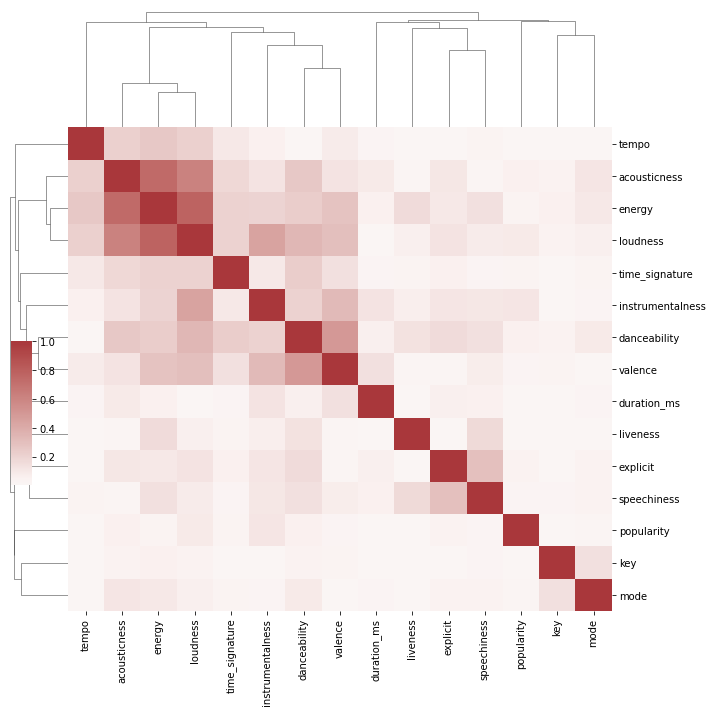

In [5]:
corr_matrix = (df.select_dtypes(exclude=['object'])
               .corr(method='pearson')
               .abs())

sns.clustermap(corr_matrix, center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2));

Drop columns with corrolation > 0.7:

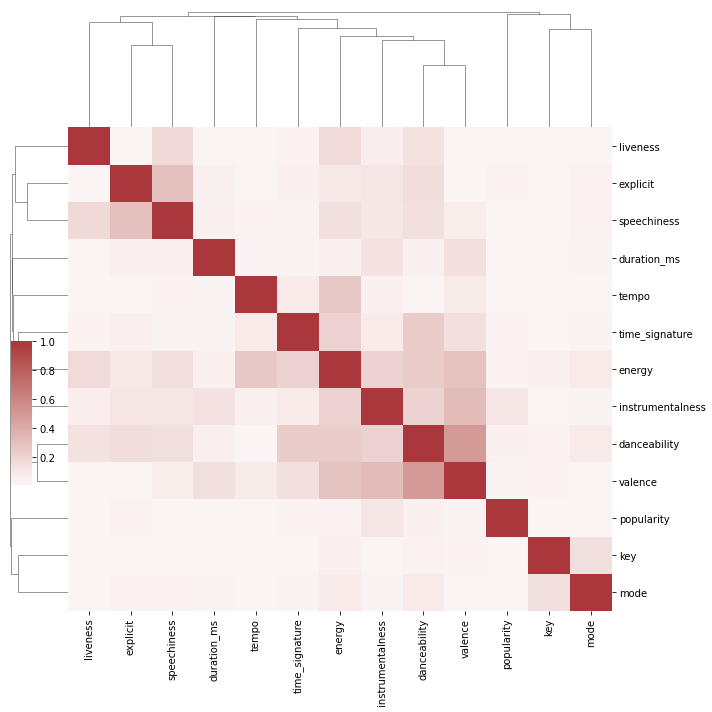

In [6]:
# Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1
# So we are selecting the upper traingular
# We should not include the diagonal elements
upper_tri_mask = np.triu(np.ones(corr_matrix.shape),k=1).astype(bool)
upper_tri = corr_matrix.where(upper_tri_mask)
# drop columns
cols_to_drop = [c for c in corr_matrix.columns if any(upper_tri[c] > 0.7)]
df.drop(columns=cols_to_drop, inplace=True)

new_corr_matrix = (df.select_dtypes(exclude=['object'])
                   .corr(method='pearson')
                   .abs())

sns.clustermap(new_corr_matrix, center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2));

In [7]:
df.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,mode,speechiness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
track_id,,,,,,,,,,,,,,,,,
5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,0,0.1430,0.000001,0.358,0.715,87.917,4,acoustic
4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,1,0.0763,0.000006,0.101,0.267,77.489,4,acoustic
1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,1,0.0557,0.000000,0.117,0.120,76.332,4,acoustic
1iJBSr7s7jYXzM8EGcbK5b,ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,1,0.0557,0.000000,0.117,0.120,76.332,4,acoustic
6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,1,0.0363,0.000071,0.132,0.143,181.740,3,acoustic


**Split data:** <br>
X and Y sets:

In [8]:
# create Y values - popular / not popular label from popularity column
df['popular_lable'] = 0
df.loc[df['popularity'] > df['popularity'].mean(), 'popular_lable'] = 1

X = df.drop(columns=['popularity', 'popular_lable'])
y = df['popular_lable']

Train and test split:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

print(f'X train shape:{X_train.shape}, y train shape:{y_train.shape}\n'
      f'X test shape:{X_test.shape}, y test shape:{y_test.shape}')

X train shape:(134548, 16), y train shape:(134548,)
X test shape:(23744, 16), y test shape:(23744,)


# Building model - Decision Tree Classifier
model pipeline: <br>
- one hot encoder - for dealing with object/non-numerical columns values<br>
- Decision Tree Classifier <br>

In [10]:
model_clf = make_pipeline(OneHotEncoder(handle_unknown='ignore'), 
                      DecisionTreeClassifier(random_state=42))
# fit the model
model_clf.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Make predictions:

In [11]:
# make predictions
y_train_pred = model_clf.predict(X_train)
y_test_pred = model_clf.predict(X_test)

# sanity check - make sure data shapes makes sense
assert y_train.shape == y_train_pred.shape, "y_train and y_train_pred shape don't match"
assert y_test.shape == y_test_pred.shape, "y_test and y_test_pred shape don't match"

print(f'y train shape:{y_train.shape}, predicted y train shape:{y_train_pred.shape}\n'
      f'y test shape:{y_test.shape}, predicted y test shape:{y_test_pred.shape}')

y train shape:(134548,), predicted y train shape:(134548,)
y test shape:(23744,), predicted y test shape:(23744,)


**Model evaluation** <br>
Confusion matrix:

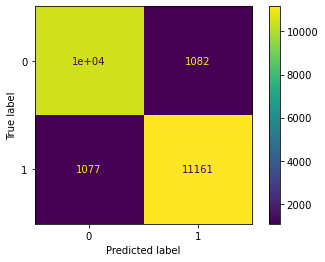

In [12]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();

Accuracy, Precision, Recall & F1-Score: <br>
- Accuracy - the ratio of true positives and true negatives to all positive and negative observations. In other words, accuracy tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.
$$ Accuracy = \frac{TP+TN}{TP+FN+TN+FP}$$

- Precision - measures the proportion of positively predicted labels that are actually correct
$$ Precision = \frac{TP}{FP+TP} $$

- Recall -  represents the model’s ability to correctly predict the positives out of actual positives
$$ Recall = \frac{TP}{FN+TP}$$

- F1-Score - represents the model score as a function of precision and recall score.
$$F1 = \frac{2* Precision * Recall}{Precision + Recall}$$

In [13]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_test_pred), '\n',
      'Precision: %.3f' % precision_score(y_test, y_test_pred), '\n', 
      'Recall: %.3f' % recall_score(y_test, y_test_pred), '\n', 
      'F1 Score: %.3f' % f1_score(y_test, y_test_pred))

Accuracy: 0.909 
 Precision: 0.912 
 Recall: 0.912 
 F1 Score: 0.912


# Building model - Decision Tree Regressor
init data split:

In [110]:
# init data split

# for a regressor - y is popularity and not popular_lable
X = df.drop(columns=['popularity', 'popular_lable'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=42)

# sanity check - make sure data shapes makes sense
print(f'X train shape:{X_train.shape}, y train shape:{y_train.shape}\n'
      f'X test shape:{X_test.shape}, y test shape:{y_test.shape}')

X train shape:(134548, 16), y train shape:(134548,)
X test shape:(23744, 16), y test shape:(23744,)


model pipeline: <br>
- one hot encoder - for dealing with object/non-numerical columns values<br>
- Decision Tree Regressor <br>

In [123]:
model_reg = make_pipeline(OneHotEncoder(handle_unknown='ignore'), 
                      DecisionTreeRegressor(random_state=42))
# fit the model
model_reg.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Make predictions:

In [124]:
# make predictions
y_train_pred = model_reg.predict(X_train)
y_test_pred = model_reg.predict(X_test)

# sanity check - make sure data shapes makes sense
assert y_train.shape == y_train_pred.shape, "y_train and y_train_pred shape don't match"
assert y_test.shape == y_test_pred.shape, "y_test and y_test_pred shape don't match"

print(f'y train shape:{y_train.shape}, predicted y train shape:{y_train_pred.shape}\n'
      f'y test shape:{y_test.shape}, predicted y test shape:{y_test_pred.shape}')

y train shape:(134548,), predicted y train shape:(134548,)
y test shape:(23744,), predicted y test shape:(23744,)


Label y (true and predicted): <br>
use popularity score to label 'popular'=1 / 'not popular'=0 


In [153]:
# helper function for mapping
# if val>avg return 1, else return 0
def _func(val, avg):
    if val > avg:
        return bool(1)
    else:
        return bool(0)

# convert popylarity scores into labels (0/1)
y_train_l = y_train.apply(_func, args=(y_train.mean(),))
y_test_l = y_test.apply(_func, args=(y_test.mean(),))
y_train_pred_l = (pd.Series(y_train_pred, index=y_train.index, name='popularity')
                .apply(_func, args=(y_train_pred.mean(),)))
y_test_pred_l = (pd.Series(y_test_pred, index=y_test.index, name='popularity')
               .apply(_func, args=(y_test_pred.mean(),)))

# sanity check
assert all([len(y_train[y_train_l]) == sum(y_train_l), 
            len(y_test[y_test_l]) == sum(y_test_l)]), 'wrong binarization'

**Model evaluation** <br>
Confusion matrix:

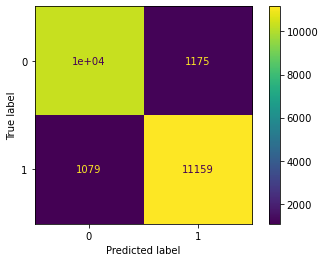

In [155]:
conf_matrix = confusion_matrix(y_true=y_test_l, y_pred=y_test_pred_l)

ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();

Accuracy, Precision, Recall & F1-Score:

In [156]:
print('Accuracy: %.3f' % accuracy_score(y_test_l, y_test_pred_l), '\n',
      'Precision: %.3f' % precision_score(y_test_l, y_test_pred_l), '\n', 
      'Recall: %.3f' % recall_score(y_test_l, y_test_pred_l), '\n', 
      'F1 Score: %.3f' % f1_score(y_test_l, y_test_pred_l))

Accuracy: 0.905 
 Precision: 0.905 
 Recall: 0.912 
 F1 Score: 0.908


**scores comparison summery:** <br>

|           | Classification | Regression |
| :-------: | :------------: | :--------: |
| Accuracy  | 0.909          | 0.905      |
| Precision | 0.912          | 0.905      |
| Recall    | 0.912          | 0.912      |
| F1 Score  | 0.912          | 0.908      |